# Predict Data. 
Version 2.0  
This time we predict using data selected using the same criteria as when preparing training data. 

Version 3.0  
Found that the problem actually originated from (probably) the model's evaluation setting, now since the running is correct we can get result simiar to that during training. 

### Import Libs

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from model_dataset import FixedHandshapeDict, GuideReader
from paths import *
from model_model import LinearHandshapePredictor
from model_configs import *
from utils import *
from recorder import *
from graph_tools import GraphTool, Plotter, Smoother

### Init Model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = LinearHandshapePredictor(
    input_dim=in_dim, 
    enc_lat_dims=enc_lat_dims, 
    hid_dim=hid_dim, 
    dec_lat_dims=dec_lat_dims, 
    output_dim=out_dim
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [3]:
model

LinearHandshapePredictor(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=63, out_features=128, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=128, out_features=128, bias=True)
      (lin2): Linear(in_features=128, out_features=128, bias=True)
      (relu): ReLU()
    )
    (2): LinPack(
      (lin): Linear(in_features=128, out_features=32, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ResBlock(
      (lin1): Linear(in_features=32, out_features=32, bias=True)
      (lin2): Linear(in_features=32, out_features=32, bias=True)
      (relu): ReLU()
    )
    (4): Linear(in_features=32, out_features=5, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=5, out_features

In [4]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

53506


In [5]:
ts = "1113174414-lin"
stop_epoch = "597"
save_subdir = os.path.join(model_save_dir, "{}/".format(ts))
model_raw_name = f"{stop_epoch}"
model_name = model_raw_name + ".pt"
model_path = os.path.join(save_subdir, model_name)
state = torch.load(model_path)
model.load_state_dict(state)
model.to(device)

LinearHandshapePredictor(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=63, out_features=128, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=128, out_features=128, bias=True)
      (lin2): Linear(in_features=128, out_features=128, bias=True)
      (relu): ReLU()
    )
    (2): LinPack(
      (lin): Linear(in_features=128, out_features=32, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ResBlock(
      (lin1): Linear(in_features=32, out_features=32, bias=True)
      (lin2): Linear(in_features=32, out_features=32, bias=True)
      (relu): ReLU()
    )
    (4): Linear(in_features=32, out_features=5, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=5, out_features

In [6]:
class HiddenViewer: 
    css_in = f"""
<head>
    <link rel="stylesheet" href="{hidview_style_path}">
</head>
"""
    frame_pred_vis = """
<div class="container">
<input type="number" id="integerInput" min="0">
<div class="output" id="outputDiv"></div>
</div>
"""
    control_script_pre = """
<script>
const integerInput = document.getElementById('integerInput');
const outputDiv = document.getElementById('outputDiv');

const stringsList ="""

    control_script_post = """
integerInput.addEventListener('input', () => {
const selectedIndex = parseInt(integerInput.value);

if (selectedIndex >= 0 && selectedIndex < stringsList.length) {
    const selectedString = stringsList[selectedIndex];
    outputDiv.textContent = selectedString;
} else {
    outputDiv.textContent = "無";
}
});
</script>
"""
    

class PredictionViewer: 
    def __init__(self, file_name, sign_name, frame_count, predictions):
        # file_name: should be sign name + left/right
        # sign_name: name of sign as in guide file
        # frame_count: total number of frames of this sign
        # predictions: list of predicted signs
        pred_nums = [str(ord(char)) for char in predictions]
        
        self.html = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>{file_name}</title>
    <link rel="stylesheet" href="{predsview_style_path}">
    <script>
        var sign = "{sign_name}"; 
        var filenum = {frame_count}; 

        var preds = {predictions}; 
        var prednums = {pred_nums}; 
    </script>
</head>
<body>
<!-- Container to center the image -->
<div id="image-container">
    <img id="image-viewer" src="" alt="Image Viewer">
</div>
<div id="text-container">
    <p id="frame-count"></p>
    <img id="text-viewer" src="" alt="Text Viewer">
    <p id="text-alt"></p>
</div>
<script src="{predsview_js_path}"></script>
</body>
</html>
"""

In [17]:
hsdict = FixedHandshapeDict()
subset_name = "Cynthia_test_poly"
subset_dir = subset_name + "/"
preds_subset_dir = "preds_try_" + subset_dir
det_sub_dir = os.path.join(det_dir, subset_dir)

linegraph_ = os.path.join(src_dir, preds_subset_dir, "line/")
spectrogram_ = os.path.join(src_dir, preds_subset_dir, "spec/")
hidden_ = os.path.join(src_dir, preds_subset_dir, "hidden_viewer/")
preds_ = os.path.join(src_dir, preds_subset_dir, "preds_viewer/")
mk(linegraph_), mk(spectrogram_), mk(hidden_), mk(preds_)
# for data_sub_dir in [linegraph_, spectrogram_, hidden_, preds_]: 
#     no_smooth_sub = os.path.join(data_sub_dir, "non/")
#     ma_smooth_sub = os.path.join(data_sub_dir, "ma/")
#     mk(no_smooth_sub), mk(ma_smooth_sub)

(None, None, None, None)

In [18]:
gr = GuideReader(guide_path)
table_list = []

sign_name_list = []
side_list = []
frame_idx_list = []
target_handshape_list = []
predicted_handshape_list = []
is_correct_list = []
anno_list = []
missing_detection_list = []

In [19]:
total = len(os.listdir(det_sub_dir))
model.eval()
for idx, clip in enumerate(os.listdir(det_sub_dir)): 
    draw_progress_bar(idx, total)
    for side in ["Right", "Left"]:
        find_name = "{}_{}".format(side, clip)
        reverse_find_name = "{}_{}".format(clip, side)

        gt = GraphTool(graph_dir, find_name)
        # gt.delete_empty()
        gt.interpolate(window_size=2)
        features = gt.interpolated_features.copy()
        # features = Smoother.moving_average(features)

        # features = gt.get_features(flatten=False)

        this_features = torch.from_numpy(features)
        batch_num, lm_num, dim_num = this_features.size()

        x = this_features
        x = x.to(device)
        x = x.to(torch.float32)

        hid_rep, pred = model.predict(x, hsdict)

        hid_rep = hid_rep.cpu().detach().numpy()

        # hidden viewer
        html = """"""
        html += HiddenViewer.css_in

        html += f"""<h1>{reverse_find_name}</h1><br>"""

        html += HiddenViewer.frame_pred_vis

        html += Plotter.plot_spectrogram(
            hid_rep, 
            title="ML Spectrogram" + side, 
            save_path= os.path.join(spectrogram_, reverse_find_name)
        )

        html += Plotter.plot_line_graph(hid_rep, ["0", "1", "2", "3", "4"], 
                                        "ML Linegraph" + side, y_axis_label="Val", 
                                        save_path= os.path.join(linegraph_, reverse_find_name))
        
        html += HiddenViewer.control_script_pre + str(pred) + HiddenViewer.control_script_post
        
        Plotter.write_to_html(html, os.path.join(hidden_, f"{reverse_find_name}.html"))

        # preds viewer
        predsviewer = PredictionViewer(
            file_name=reverse_find_name, 
            sign_name=clip, 
            frame_count=len(os.listdir(os.path.join(det_sub_dir, clip))), 
            predictions=pred
        )
        Plotter.write_to_html(predsviewer.html, os.path.join(preds_, f"{reverse_find_name}.html"))

        # result table
        anno = "HS"
        target_handshape = gr.extract_allkinds(clip)
        if side == "Right": 
            target = target_handshape.dexter
        elif side == "Left": 
            target = target_handshape.sinister
        else: 
            target = " "
        if not target: 
            target = "x" # no handshape, this will show as space faithfully
            anno = "NHS"

        total_number = len(pred)

        sign_name_list += [clip] * total_number
        side_list += [side] * total_number
        frame_idx_list += list(range(total_number))
        target_handshape_list += [target] * total_number
        predicted_handshape_list += pred
        is_correct_list += (np.array(pred) == target).astype(int).tolist()
        anno_list += [anno] * total_number
        missing_detection_list += gt.flag.tolist()

data = {
    "sign_name": sign_name_list, 
    "side": side_list, 
    "frame_idx": frame_idx_list, 
    "target": target_handshape_list, 
    "predicted": predicted_handshape_list, 
    "is_correct": is_correct_list, 
    "anno": anno_list, 
    "missing_detection": missing_detection_list
}
df = pd.DataFrame(data)
df.to_excel(src_dir + f"HKSL_Prediction_{subset_name}.xlsx")

 [==================================================] 99%

In [38]:
subset_name = "Cynthia_test_mono"

In [39]:
df = pd.read_excel(src_dir + f"HKSL_Prediction_{subset_name}.xlsx")
testdf = df[df["side"] == "Right"]
testdf = testdf[testdf["missing_detection"] == 1]
right_detect = testdf["is_correct"].sum()/len(testdf["is_correct"])

testdf = df[df["side"] == "Left"]
testdf = testdf[testdf["missing_detection"] == 1]
left_detect = testdf["is_correct"].sum()/len(testdf["is_correct"])

testdf = df[df["side"] == "Right"]
right_all = testdf["is_correct"].sum()/len(testdf["is_correct"])

testdf = df[df["side"] == "Left"]
left_all = testdf["is_correct"].sum()/len(testdf["is_correct"])

0.3347723704866562
0.4357832219747587
0.28269925020827547
0.4548736462093863


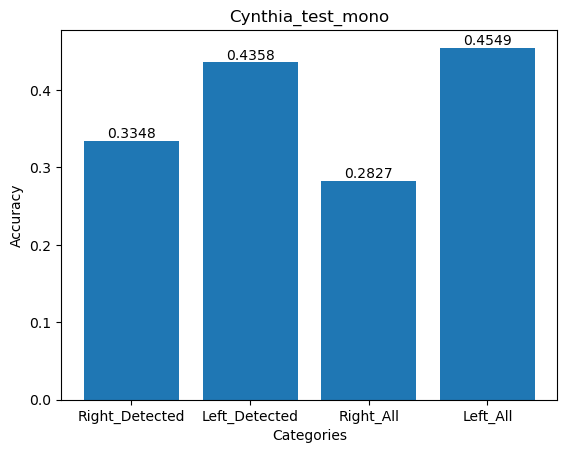

In [40]:
# Assuming you have a list of categories and corresponding values
categories = ['Right_Detected', 'Left_Detected', 'Right_All', 'Left_All']
values = [right_detect, left_detect, right_all, left_all]

bars = plt.bar(categories, values)

for bar in bars:
    height = bar.get_height()
    print(height)
    plt.text(bar.get_x() + bar.get_width() / 2, height,
                f'{round(height, 4)}', ha='center', va='bottom')
plt.xlabel('Categories')
plt.ylabel('Accuracy')
plt.title(f'{subset_name}')
plt.show()